In [1]:
from torchvision.datasets import CIFAR100
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torchvision.models import alexnet
from torchsummary import summary
import datetime

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
#ImageNet中，使用mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
#从零开始训练选择[0.5,0.5,0.5],否则选择上面的

# 加载数据

In [3]:
train_dataset = CIFAR100(r'C:\Users\caeit\Desktop\cifar100',download=True,\
                         transform=transform,train=True)
test_dataset = CIFAR100(r'C:\Users\caeit\Desktop\cifar100',download=True,\
                        transform=transform,train=False)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=16,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# 用permute，不要用reshape和view，切记切记

# 图片在显示的时候，[0,1]的float64，或者[0,255]的uint8

In [4]:
mean = [0.5,0.5,0.5]
std = [0.5,0.5,0.5]

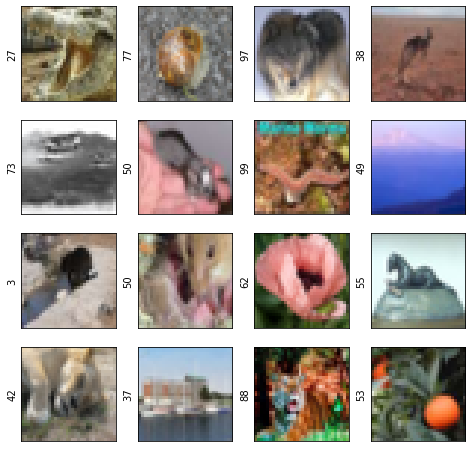

In [5]:
x,y = next(iter(train_loader))

plt.figure(figsize=(8,8))
for i in range(16):
    b = x[i].permute(1,2,0)
    x2 = np.array(b)
    x2 = x2*std+mean
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('%d'%y[i].data)
    plt.imshow(x2)  ##如果reshape或view，会显示九张图片

# 用AlexNet试试

In [6]:
alexnet1 = alexnet()
alexnet1.load_state_dict(torch.load(r"C:\Users\caeit\.cache\torch\checkpoints\alexnet-owt-4df8aa71.tar"))  #使用预训练好的参数

<All keys matched successfully>

# cifar100图片太小,无法直接输入AlexNet模型
* 要么把图片插值到224*224
* 要么调整卷积层

In [7]:
#调整卷积层
import torch.nn as nn
alexnet1.features[0] = nn.Conv2d(3,64,kernel_size=(5,5),stride=(1,1),padding=(2,2))
alexnet1.classifier[6] = nn.Linear(4096,100)

In [8]:
print(alexnet1)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

In [9]:
alexnet1 = alexnet1.cuda()
summary(alexnet1,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 192, 15, 15]         307,392
              ReLU-5          [-1, 192, 15, 15]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         590,080
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
AdaptiveAvgPool2d-14            [-1, 25

* 设置损失函数和优化器

In [10]:
alexnet1 = alexnet1.cuda(1)  #第一个GPU在训练，换成第二个
cost = torch.nn.CrossEntropyLoss().cuda(1)
optimizer = torch.optim.Adam(alexnet1.parameters(),lr=1e-4)

In [14]:
start = datetime.datetime.now()
for i in range(3):
    correct = 0.0
    running_loss = 0.0
    accuracy = 0.0
    print('-----epoch', i+1, '-----')
    for num, (x_train, y_train) in enumerate(train_loader):
        x_train,y_train = x_train.cuda(1),y_train.cuda(1)
        optimizer.zero_grad()
        output = alexnet1(x_train)
        loss = cost(output, y_train)
        _, predicted = torch.max(output, 1)
        correct += (predicted == y_train).sum().item()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if num%500 == 1:
            print('loss:', running_loss, ',accuracy:{}%'.format((100*correct/((num+1)*16))),'correct numbers:%s'%correct)
    print('---------------------------')
print(datetime.datetime.now()-start)
torch.save(alexnet1,'cifar100.pkl')

# 训练集上准确度能达到94.63%，再看看测试集

In [2]:
alexnet1 = torch.load('cifar100.pkl')
correct = 0 
for num, (x_train, y_train) in enumerate(test_loader):
    x_train,y_train = x_train.cuda(1),y_train.cuda(1)
    output = alexnet1(x_train)
    _, predicted = torch.max(output, 1)
    correct += (predicted == y_train).sum().item()
print('accuracy:{}%'.format((100*correct/((num+1)*16))),'correct numbers:%s'%correct,'total test number:',(num+1)*16)
print('-------------------------------------------------------------')

In [21]:
# 测试集上48.51%的准确率，对于100分类的cifar100数据集而言效果一般